<a href="https://colab.research.google.com/github/anirban6908/All-active-Manuscript/blob/master/notebooks/Classification/SVM_classification.ipynb">
   <img align="left" 
      src="https://colab.research.google.com/assets/colab-badge.svg">
</a>
<a href="https://mybinder.org/v2/gh/anirban6908/All-active-Manuscript/blob/master/notebooks/Classification/SVM_classification.ipynb/master">
   <img align="left" 
      src="https://mybinder.org/badge_logo.svg">
</a>
<a href="https://nbviewer.jupyter.org/github/anirban6908/All-active-Manuscript/blob/master/notebooks/Classification/SVM_classification.ipynb">
   <img align="right" 
      src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.png" 
      width="109" height="20">
</a>

## SVM classification (Figure 3)


In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ateamopt.utils import utility
import man_opt.utils as man_utils
import os
import numpy as np
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,accuracy_score  
from sklearn.model_selection import StratifiedKFold,GridSearchCV,\
            RandomizedSearchCV,train_test_split  
from sklearn.utils.multiclass import unique_labels
import scipy.stats as stats  

### SVM Classifier (with hyperparameter tuning on C and gamma)

In [3]:
def SVM_classifier(X_df,y_df,feature_fields,target_field,hyp_search='random'):
        np.random.seed(0)
        svm_pipeline =  Pipeline([('scaler', StandardScaler()),
                                      ('svc', SVC(kernel='rbf'))])
        le = preprocessing.LabelEncoder()  
        y_df['label_encoder']= le.fit_transform(y_df[target_field])
        
        X_data = X_df.loc[:,feature_fields].values
        y_data = y_df['label_encoder'].values
        
        X_train, X_test, y_train, y_test = train_test_split(
                X_data, y_data, test_size=0.3, stratify=y_data, random_state=0)
        
        ## Hyperparameter selection
        n_tune_split = 3
        
        if hyp_search == 'grid':
        
            ## Grid Search
            param_grid = {'svc__C':np.logspace(-2,3,100),'svc__gamma':np.logspace(-4,0,10)}
            tuned_pipeline = GridSearchCV(svm_pipeline, param_grid,
                                              cv=n_tune_split,n_jobs=4).fit(X_train, y_train)

        else:
            ## Randomized Search
            n_iter = 1000
            param_distrib = {'svc__C':stats.loguniform(1e-2,1000),
                             'svc__gamma':stats.loguniform(1e-4,1)}
            
            tuned_pipeline = RandomizedSearchCV(svm_pipeline, param_distrib, 
                        cv=n_tune_split,n_iter=n_iter,random_state=0,n_jobs=4).fit(X_train, y_train)
        
        tuned_C, tuned_gamma = (tuned_pipeline.best_params_['svc__C'],
                                    tuned_pipeline.best_params_['svc__gamma'])

        print('Tuned hyperparameters : C = %s, gamma = %s\n'%(tuned_C, tuned_gamma))
            
        y_pred_test = tuned_pipeline.predict(X_test)
        y_pred_chance = np.random.choice(y_test,len(y_test))
        confusion_matrix_svm = confusion_matrix(y_test, y_pred_test)
        
        score = accuracy_score(y_test, y_pred_test)
        chance_score = accuracy_score(y_test, y_pred_chance)
        
        classes = le.inverse_transform(unique_labels(y_test, \
                                        y_pred_test))
        
        df_conf_svm = pd.DataFrame(confusion_matrix_svm, classes,
              classes)
        df_conf_svm=df_conf_svm.div(df_conf_svm.sum(axis=1),axis=0) # Fraction of the actual no.s
        
        df_conf_svm *= 100
        delta_chance = score - chance_score  
        score = np.round(100*score,1)
        delta_chance = np.round(delta_chance*100,1)
        
        test_y_pred,test_y = le.inverse_transform(y_pred_test),\
                                    le.inverse_transform(y_test)
        
        return score,df_conf_svm,delta_chance,test_y,test_y_pred

### Datapaths for the all-active models 

In [4]:
data_path = os.path.join(os.getcwd(),os.pardir,os.pardir,'assets','aggregated_data')
mouse_data_filename = os.path.join(data_path,'Mouse_class_data.csv')
mouse_datatype_filename = os.path.join(data_path,'Mouse_class_datatype.csv')

morph_data_filename = os.path.join(data_path,'morph_data.csv')
morph_datatype_filename = os.path.join(data_path,'morph_datatype.csv')

sdk_data_filename = os.path.join(data_path,'sdk.csv')
sdk_datatype_filename = os.path.join(data_path,'sdk_datatype.csv')

param_data_filename = os.path.join(data_path,'allactive_params.csv')
param_datatype_filename = os.path.join(data_path,'allactive_params_datatype.csv')

train_ephys_max_amp_fname = os.path.join(data_path,'train_ephys_max_amp.csv')
train_ephys_max_amp_dtype_fname = os.path.join(data_path,'train_ephys_max_amp_dtype.csv')
train_ephys_max_amp_fields_fname = os.path.join(data_path,'train_ephys_max_amp_fields.json')

cre_coloring_filename = os.path.join(data_path,'rnaseq_sorted_cre.pkl')

### Read the data

In [5]:
mouse_data_df = man_utils.read_csv_with_dtype(mouse_data_filename,mouse_datatype_filename)
morph_data = man_utils.read_csv_with_dtype(morph_data_filename,morph_datatype_filename)
morph_fields = man_utils.get_data_fields(morph_data)
allensdk_data = man_utils.read_csv_with_dtype(mouse_data_filename,mouse_datatype_filename)
allensdk_fields = man_utils.get_data_fields(allensdk_data)
ephys_data = man_utils.read_csv_with_dtype(train_ephys_max_amp_fname,
                                                  train_ephys_max_amp_dtype_fname)
ephys_fields = utility.load_json(train_ephys_max_amp_fields_fname)
hof_param_data = man_utils.read_csv_with_dtype(param_data_filename,param_datatype_filename)

cre_cluster = mouse_data_df.loc[mouse_data_df.hof_index==0,['Cell_id','Cre_line']]
bcre_cluster = mouse_data_df.loc[mouse_data_df.hof_index==0,['Cell_id','Broad_Cre_line']]

cre_color_dict = utility.load_pickle(cre_coloring_filename)
rna_seq_crelines = list(cre_color_dict.keys())
all_crelines = cre_cluster.Cre_line.unique().tolist()
cre_pal_all = {cre_:(mpl.colors.to_hex(cre_color_dict[cre_]) 
        if cre_ in rna_seq_crelines else 
             mpl.colors.to_hex('k')) for cre_ in all_crelines}


### Classifier grid composed of different features and targets

In [6]:
me_fields= ephys_fields + morph_fields
me_data = pd.merge(ephys_data,morph_data, how='left',on='Cell_id')
param_data = hof_param_data.loc[hof_param_data.hof_index == 0,]
param_data = param_data.drop(labels='hof_index',axis=1)
p_fields = list(param_data)
mp_fields= morph_fields+p_fields
mp_data = pd.merge(morph_data,param_data, how='left',on='Cell_id')


target_field_list = ['Broad_Cre_line','Cre_line']
target_name_list = ['Broad Cre-line','Cre-line']

feature_field_list = [ephys_fields,me_fields,p_fields,mp_fields]
feature_name_list = ['Ephys','Morph+Ephys','Model Parameters','Morph+Parameters']
feature_data_list = [ephys_data,me_data,param_data,mp_data]
cluster_data_list = [bcre_cluster,cre_cluster]

svm_scores_arr = np.zeros((len(target_field_list),len(feature_field_list)))
svm_conf_mat_grid = {}
test_pred_record = {}
delta_chance_arr = np.zeros_like(svm_scores_arr)
least_pop_index = 6

for ii,target_ in enumerate(target_field_list):
    for jj,feature_ in enumerate(feature_field_list):
        
        feature_fields = [feature_field_ for feature_field_ in feature_ \
                  if feature_field_ != 'Cell_id']
        
        feature_data = feature_data_list[jj]
        cluster_data = cluster_data_list[ii]
        df_clf = pd.merge(feature_data,cluster_data,how='left',
                        on='Cell_id')
        
        if target_ == 'Cre_line':
            df_clf = df_clf.loc[df_clf[target_].isin(rna_seq_crelines),]
            
        X_df,y_df,revised_features = man_utils.prepare_data_clf\
            (df_clf,feature_fields,target_,
            least_pop=least_pop_index)
        
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print('Classifier Features : %s'%feature_name_list[jj])
        print('Classifier Target : %s'%target_)
        
        score,conf_df,delta_chance,test_y,test_y_pred= SVM_classifier(X_df,\
                 y_df,revised_features,target_,hyp_search='grid')
        
        if target_ == 'Broad_Cre_line':
            bcre_index_order = ['Htr3a','Sst','Pvalb','Pyr']
            conf_df = conf_df.reindex(index=bcre_index_order,columns=bcre_index_order)

        elif target_ == 'Cre_line':
            cre_indices = conf_df.index
            sorted_cre_indices = [cre_ind_ for cre_ind_ in rna_seq_crelines \
                                  if cre_ind_ in cre_indices]
            conf_df = conf_df.reindex(index=sorted_cre_indices,columns=
                                      sorted_cre_indices)
            cre_indices = [cre.split('-')[0] for cre in sorted_cre_indices]
            conf_df=pd.DataFrame(conf_df.values,index=cre_indices,columns=cre_indices)
        
        print('Classifier Accuracy : %s'%score)
        svm_scores_arr[ii,jj] = score
        svm_conf_mat_grid[ii,jj] = conf_df
        delta_chance_arr[ii,jj] = delta_chance    
        test_pred_record[ii,jj] = pd.DataFrame({'true':test_y,'predicted':test_y_pred})
    


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Classifier Features : Ephys
Classifier Target : Broad_Cre_line


/allen/aibs/mat/ateam_shared/optimization_software/conda/ateam_opt/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Tuned hyperparameters : C = 15.199110829529332, gamma = 0.002154434690031882

Classifier Accuracy : 83.3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Classifier Features : Morph+Ephys
Classifier Target : Broad_Cre_line


/allen/aibs/mat/ateam_shared/optimization_software/conda/ateam_opt/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Tuned hyperparameters : C = 5.994842503189409, gamma = 0.002154434690031882

Classifier Accuracy : 85.2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Classifier Features : Model Parameters
Classifier Target : Broad_Cre_line


/allen/aibs/mat/ateam_shared/optimization_software/conda/ateam_opt/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Tuned hyperparameters : C = 123.28467394420659, gamma = 0.0002782559402207126

Classifier Accuracy : 68.5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Classifier Features : Morph+Parameters
Classifier Target : Broad_Cre_line


/allen/aibs/mat/ateam_shared/optimization_software/conda/ateam_opt/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Tuned hyperparameters : C = 2.364489412645407, gamma = 0.016681005372000592

Classifier Accuracy : 79.6
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Classifier Features : Ephys
Classifier Target : Cre_line


/allen/aibs/mat/ateam_shared/optimization_software/conda/ateam_opt/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Tuned hyperparameters : C = 17.073526474706906, gamma = 0.12915496650148828

Classifier Accuracy : 51.9
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Classifier Features : Morph+Ephys
Classifier Target : Cre_line


/allen/aibs/mat/ateam_shared/optimization_software/conda/ateam_opt/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Tuned hyperparameters : C = 9.545484566618338, gamma = 0.000774263682681127

Classifier Accuracy : 51.9
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Classifier Features : Model Parameters
Classifier Target : Cre_line


/allen/aibs/mat/ateam_shared/optimization_software/conda/ateam_opt/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Tuned hyperparameters : C = 86.97490026177834, gamma = 0.000774263682681127

Classifier Accuracy : 32.7
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Classifier Features : Morph+Parameters
Classifier Target : Cre_line
Tuned hyperparameters : C = 3.7649358067924674, gamma = 0.016681005372000592

Classifier Accuracy : 55.8


/allen/aibs/mat/ateam_shared/optimization_software/conda/ateam_opt/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Figure grid

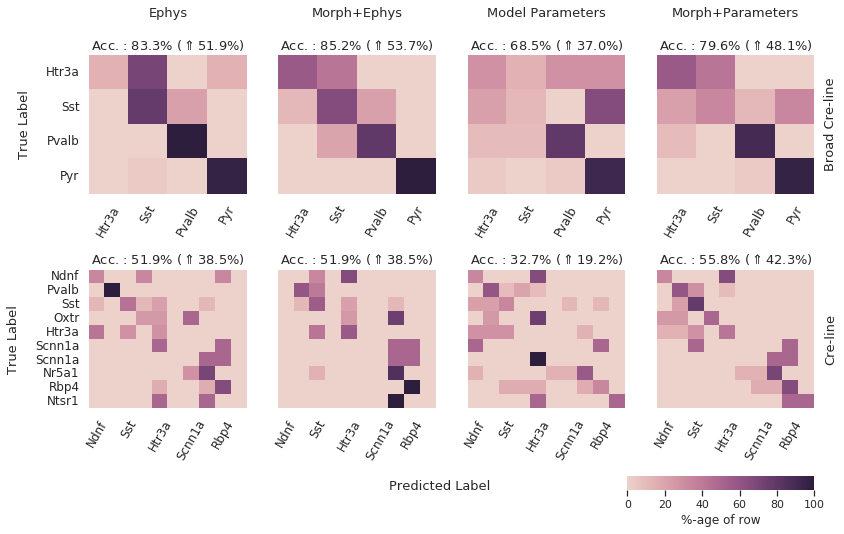

In [7]:
title_fontsize =13
axis_fontsize = 13
tick_fontsize = 12

fig_dim_x = svm_scores_arr.shape[0]
fig_dim_y = svm_scores_arr.shape[1]

sns.set(style="whitegrid")
#cmap = sns.cubehelix_palette(light=1, as_cmap=True)
cmap = sns.cubehelix_palette(as_cmap=True)

fig,axes=plt.subplots(fig_dim_x,fig_dim_y,figsize =(13,6.5),sharex=False,
                      sharey='row',squeeze=False)
for ii in range(fig_dim_x):
    for jj in range(fig_dim_y):

        axes[ii,jj] = sns.heatmap(svm_conf_mat_grid[ii,jj],cmap=cmap,
                vmin=0,vmax=100,cbar=False,linecolor='k',ax=axes[ii,jj])
        xticklabels = axes[ii,jj].get_xticklabels()
        
        if ii == 0:
            xticktext = xticklabels # For broad Cre-line show all x-labels
            feature_title = feature_name_list[jj] + '\n' + '\n'
            
        else:
            xticktext = [tick.get_text() if ii%2 == 0 else '' for ii,tick in \
                     enumerate(xticklabels)] # For refined Cre-lines show only few x-labels
            feature_title = ''
        axes[ii,jj].set_xticklabels(xticktext,rotation=60,ha='center',
                 fontsize=tick_fontsize)
        plt.setp(axes[ii,jj].get_yticklabels(),rotation=0,va='center',
                 fontsize=tick_fontsize)
        
        target_title = target_name_list[ii]
        if jj == 0:
            axes[ii,jj].set_ylabel('True Label',labelpad=15,fontsize=axis_fontsize)
        elif jj == fig_dim_y-1:
            axes[ii,jj].set_ylabel(target_title,labelpad=10,fontsize=axis_fontsize)
            axes[ii,jj].yaxis.set_label_position("right")
        prefix_title = 'Acc. : {}% '.format(svm_scores_arr[ii,jj])
        percent_text = r'$(\Uparrow{}\%)$'.format(delta_chance_arr[ii,jj])
        axes[ii,jj].set_title(feature_title+prefix_title+percent_text,fontsize=title_fontsize)

fig.text(0.5, -0.05, 'Predicted Label', ha='center',fontsize=axis_fontsize)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
sm._A = []
cax = fig.add_axes([0.7, -0.05, 0.2, .03])
cbar = fig.colorbar(sm,orientation='horizontal',cax=cax)
cbar.ax.set_xlabel('%-age of row',fontsize=tick_fontsize)
cbar.outline.set_visible(False)

fig.subplots_adjust(wspace=.2,hspace=.55)
svm_figpath = 'figures/SVM_Classifier_grid.pdf'
utility.create_filepath(svm_figpath)
fig.savefig(svm_figpath,bbox_inches='tight')
plt.show()
    

### Performance of our flagship classifier (Morph + parameters) 

In [8]:
%%html
<style>
.sankey .node {
    font-size:100%;
}
</style>

In [9]:
from floweaver import *

### Flow diagram for Broad Cre-line targets on the test set

In [10]:
bcre_dict = {'Pyr':'Rbp4-Cre_KL100','Pvalb':'Pvalb-IRES-Cre',
                 'Sst':'Sst-IRES-Cre','Htr3a':'Htr3a-Cre_NO152'} # Used Rbp4 for Pyr just to denote the red color
bcre_index_order = ['Htr3a','Sst','Pvalb','Pyr']
bcre_colorDict = {cre_:mpl.colors.to_hex(cre_color_dict[bcre_dict[cre_]]) for cre_ in bcre_index_order}
cre_colorDict = {cre_:mpl.colors.to_hex(cre_color_dict[cre_]) for cre_ in rna_seq_crelines}

In [11]:
# Broad Cre-line
svm_bcre = test_pred_record[0,3]
svm_bcre_grp = svm_bcre.groupby(list(svm_bcre))
svm_bcre_flow = pd.DataFrame({'value':svm_bcre_grp.size()}).reset_index()
svm_bcre_flow = svm_bcre_flow.rename(columns={'true':'source','predicted':'target'})
svm_bcre_flow.head()

,source,target,value
0,Htr3a,Htr3a,4
1,Htr3a,Sst,3
2,Pvalb,Htr3a,1
3,Pvalb,Pvalb,9
4,Pyr,Pvalb,1


In [12]:
partition_bcre_true = Partition.Simple('process',bcre_index_order)
partition_bcre_predicted = Partition.Simple('process',bcre_index_order)

nodes = {
    'True_SVM': ProcessGroup(bcre_index_order, partition_bcre_true,title='True'),
    'Prdicted_SVM': ProcessGroup(bcre_index_order, partition_bcre_predicted,title='Predicted')
}

bundles = [
    Bundle('True_SVM', 'Prdicted_SVM'),
]
ordering = [
    ['True_SVM'],
    ['Prdicted_SVM'],
]
flow_by_bcre =  Partition.Simple('source', bcre_index_order)

sdd = SankeyDefinition(nodes, bundles, ordering,flow_partition=flow_by_bcre)
size = dict(width=500, height=300)
weave(sdd, svm_bcre_flow,palette=bcre_colorDict) \
    .to_widget(**size).auto_save_svg('figures/svm_bcre.svg')

SankeyWidget(groups=[{'id': 'True_SVM', 'type': 'process', 'title': 'True', 'nodes': ['True_SVM^Htr3a', 'True_…

### Flow diagram for refined Cre-line target on the test set

In [13]:
# Cre-line
svm_cre = test_pred_record[1,3]
svm_cre_grp = svm_cre.groupby(list(svm_cre))
svm_cre_flow = pd.DataFrame({'value':svm_cre_grp.size()}).reset_index()
svm_cre_flow = svm_cre_flow.rename(columns={'true':'source','predicted':'target'})
svm_cre_flow.head()

,source,target,value
0,Htr3a-Cre_NO152,Htr3a-Cre_NO152,3
1,Htr3a-Cre_NO152,Ndnf-IRES2-dgCre,1
2,Htr3a-Cre_NO152,Pvalb-IRES-Cre,1
3,Htr3a-Cre_NO152,Sst-IRES-Cre,2
4,Ndnf-IRES2-dgCre,Htr3a-Cre_NO152,2


In [14]:
partition_cre_true = Partition.Simple('process',rna_seq_crelines)
partition_cre_predicted = Partition.Simple('process',rna_seq_crelines)

nodes = {
    'True_SVM': ProcessGroup(rna_seq_crelines, partition_cre_true,title='True'),
    'Prdicted_SVM': ProcessGroup(rna_seq_crelines, partition_cre_predicted,title='Predicted')
}

bundles = [
    Bundle('True_SVM', 'Prdicted_SVM'),
]
ordering = [
    ['True_SVM'],
    ['Prdicted_SVM'],
]
flow_by_cre =  Partition.Simple('source', rna_seq_crelines)

sdd = SankeyDefinition(nodes, bundles, ordering,flow_partition=flow_by_cre)
size = dict(width=550, height=350, margins=dict(left=150, right=150))
weave(sdd, svm_cre_flow,palette=cre_colorDict) \
    .to_widget(**size).auto_save_svg('figures/svm_cre.svg')

SankeyWidget(groups=[{'id': 'True_SVM', 'type': 'process', 'title': 'True', 'nodes': ['True_SVM^Ndnf-IRES2-dgC…